# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\all_data


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [3]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_reg2.ant' 

data_file01 = '../../data/interim/generated_data/simplTeusink-reg2/Simplified_Teusink_reg2_0.1.csv'
data_file02 = '../../data/interim/generated_data/simplTeusink-reg2/Simplified_Teusink_reg2_0.2.csv'
data_file03 = '../../data/interim/generated_data/simplTeusink-reg2/Simplified_Teusink_reg2_0.3.csv'
data_file04 = '../../data/interim/generated_data/simplTeusink-reg2/Simplified_Teusink_reg2_0.4.csv'
data_file05 = '../../data/interim/generated_data/simplTeusink-reg2/Simplified_Teusink_reg2_0.5.csv'
data_file10 = '../../data/interim/generated_data/simplTeusink-reg2/Simplified_Teusink_reg2_1.01.csv'

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# data_files = [data_file05, data_file10, data_file15, data_file3, data_file5, data_file7, data_file100]

1.0077414646998453e-15

In [ ]:
BMCA_obj01 = BMCA.BMCA(Teusink_ant, data_file01)
BMCA_obj02 = BMCA.BMCA(Teusink_ant, data_file02)
BMCA_obj03 = BMCA.BMCA(Teusink_ant, data_file03)
BMCA_obj04 = BMCA.BMCA(Teusink_ant, data_file04)
BMCA_obj05 = BMCA.BMCA(Teusink_ant, data_file05)
BMCA_obj10 = BMCA.BMCA(Teusink_ant, data_file10)


In [5]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,065.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,487.7


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,251.2


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,161.6


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,118.3


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,030.3


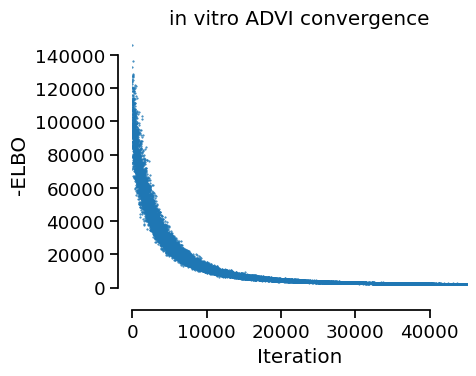

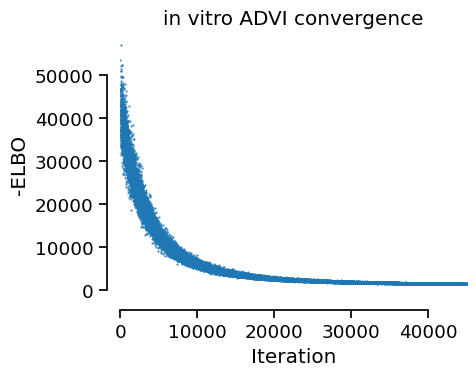

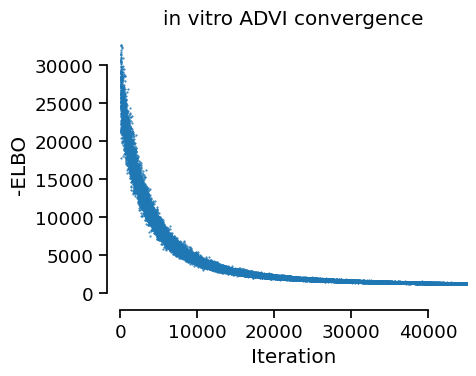

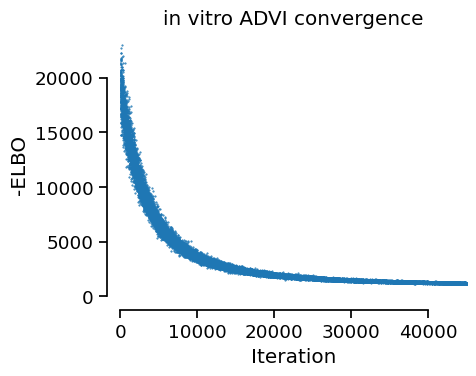

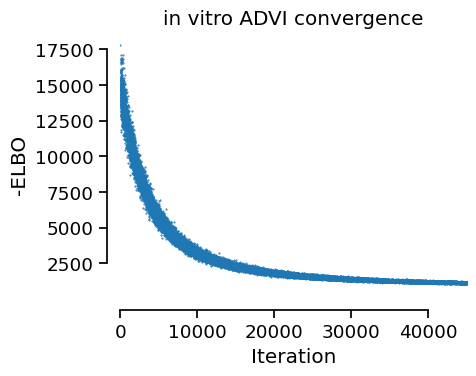

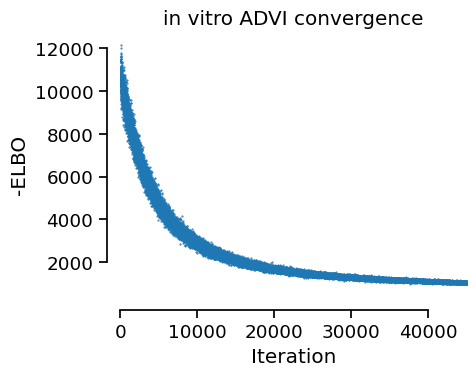

In [6]:
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)
trace05 = run_ADVI(BMCA_obj05)
trace10 = run_ADVI(BMCA_obj10)


In [7]:
# Ey_advi = (trace['posterior']['Ey']).to_numpy().squeeze()
ExTrace_01 = (trace01['posterior']['Ex']).to_numpy().squeeze()
ExTrace_02 = (trace02['posterior']['Ex']).to_numpy().squeeze()
ExTrace_03 = (trace03['posterior']['Ex']).to_numpy().squeeze()
ExTrace_04 = (trace04['posterior']['Ex']).to_numpy().squeeze()
ExTrace_05 = (trace05['posterior']['Ex']).to_numpy().squeeze()
ExTrace_10 = (trace10['posterior']['Ex']).to_numpy().squeeze()


In [8]:
medEx_01 = np.median(ExTrace_01, axis=0)
medEx_02 = np.median(ExTrace_02, axis=0)
medEx_03 = np.median(ExTrace_03, axis=0)
medEx_04 = np.median(ExTrace_04, axis=0)
medEx_05 = np.median(ExTrace_05, axis=0)
medEx_10 = np.median(ExTrace_10, axis=0)

In [9]:
# first regulator, PYR on PFK
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['vPFK']]
for i in [medEx_01, medEx_02, medEx_03, medEx_04, medEx_05, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['vPFK']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.1x', '0.2x', '0.3x', '0.4x', '0.5x', '1.01x'], axis='columns') 

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
G6P,0.000000,0.013773,0.011786,0.009478,0.001629,0.000904,0.000353
TRIO,0.000000,0.121873,0.024271,0.014370,0.006959,-0.001753,-0.006769
ACE,0.000000,0.162477,0.041263,0.013316,-0.003056,0.000076,-0.006775
P3G,0.000000,-0.005094,0.002111,0.001271,0.003777,0.001152,-0.002678
PEP,0.000000,-0.008394,-0.012890,0.004826,-0.009879,-0.003873,-0.002227
GLCi,0.000000,-0.004633,0.010261,0.010712,0.005916,0.003481,0.005962
F6P,1.066642,0.168734,0.262419,0.308975,0.370348,0.437821,0.985047
BPG,0.000000,0.022049,0.013487,-0.001204,-0.002953,0.006398,0.001176
PYR,-0.667279,-0.014556,-0.027467,-0.021750,-0.017690,-0.010348,-0.005748
F16P,-0.220572,-0.009300,0.028674,0.023821,0.019043,-0.051835,-0.778055


In [10]:
# second regulator, P3G on PGI
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['vPGI']]
for i in [medEx_01, medEx_02, medEx_03, medEx_04, medEx_05, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['vPGI']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.1x', '0.2x', '0.3x', '0.4x', '0.5x', '1.01x'], axis='columns') 

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
G6P,1.210837,0.119163,0.323871,0.414788,0.481738,0.552411,0.950933
TRIO,0.000000,0.143642,0.040909,0.023313,0.009192,0.004242,0.002783
ACE,0.000000,0.200931,0.045607,0.009307,0.000879,-0.005860,0.007462
P3G,-0.655794,-0.025266,-0.030176,-0.015120,-0.016745,-0.005245,0.000034
PEP,0.000000,-0.004636,-0.003418,-0.005849,-0.000487,0.002960,-0.000944
GLCi,0.000000,0.003562,-0.001138,-0.004747,0.000616,-0.002700,0.005974
F6P,-0.393974,0.010704,-0.032570,-0.076587,-0.131293,-0.167397,-0.905147
BPG,0.000000,0.014843,0.017683,0.004283,-0.009106,-0.003716,-0.005278
PYR,0.000000,0.025401,-0.007622,-0.006266,-0.002252,-0.001392,-0.004685
F16P,0.000000,0.022930,0.030449,0.016417,0.002709,0.012060,0.000235


## Calculating FCCs

In [11]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [12]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


### Negative predictions

In [13]:
postFCC01 = estimate_CCs(BMCA_obj01, ExTrace_01)
postFCC02 = estimate_CCs(BMCA_obj02, ExTrace_02)
postFCC03 = estimate_CCs(BMCA_obj03, ExTrace_03)
postFCC04 = estimate_CCs(BMCA_obj04, ExTrace_04)
postFCC05 = estimate_CCs(BMCA_obj05, ExTrace_05)
postFCC10 = estimate_CCs(BMCA_obj10, ExTrace_10)


In [14]:
rxn_FCCs = [postFCC01,postFCC02,postFCC03,postFCC04,postFCC05, postFCC10]
pt_labels = ['0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x']

In [15]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [16]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

,,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vGLK,0.1x,-1.840516,0.042853,0.032079,0.327920,0.144577,-0.000008,-0.004641,-0.004008,-0.002416,-0.000295,-0.000752,0.001813,-0.005218,0.335584,-0.013992,-0.003652
vPGI,0.1x,0.038098,-1.405222,-0.008608,-0.087997,0.895976,0.006038,-0.051556,-0.028239,-0.007770,0.002999,0.008346,0.010339,-0.052605,0.091607,-0.141065,-0.033824
vGLYCO,0.1x,0.207247,-0.094371,-1.041898,-0.428288,-0.140002,0.000697,0.010784,0.005000,-0.001104,-0.001346,-0.005251,-0.003971,0.008863,0.431758,0.023766,0.004056
vTreha,0.1x,0.209611,-0.048427,-0.042085,-1.430200,-0.150415,-0.002649,0.007818,0.004346,-0.003297,-0.002440,-0.005546,-0.004078,0.004856,0.437783,0.013022,0.001772
vPFK,0.1x,0.038098,0.594778,-0.008608,-0.087997,-1.104024,0.006038,-0.051556,-0.028239,-0.007770,0.002999,0.008346,0.010339,-0.052605,0.091607,-0.141065,-0.033824


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_13764\3859003407.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

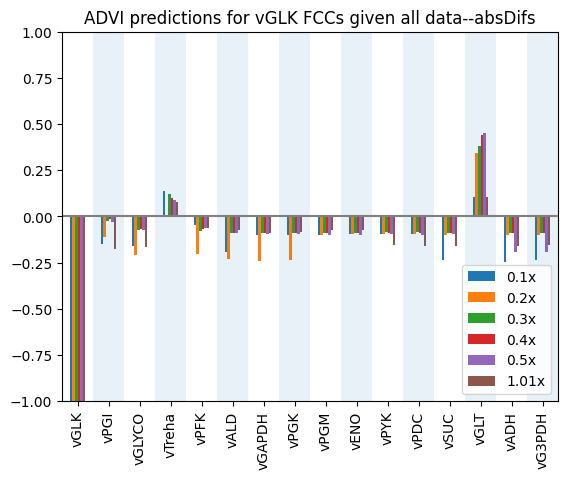

<Figure size 1600x1000 with 0 Axes>

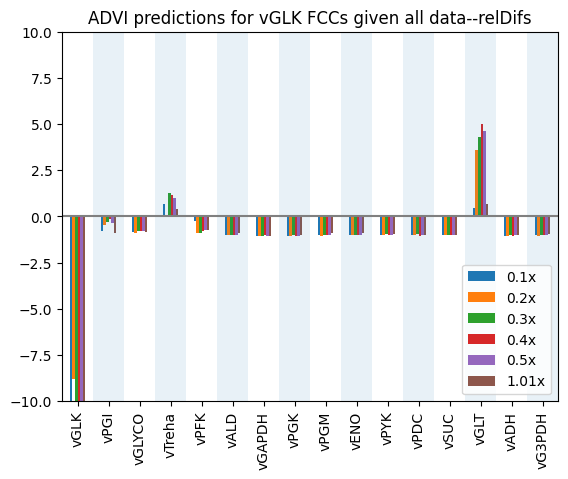

<Figure size 1600x1000 with 0 Axes>

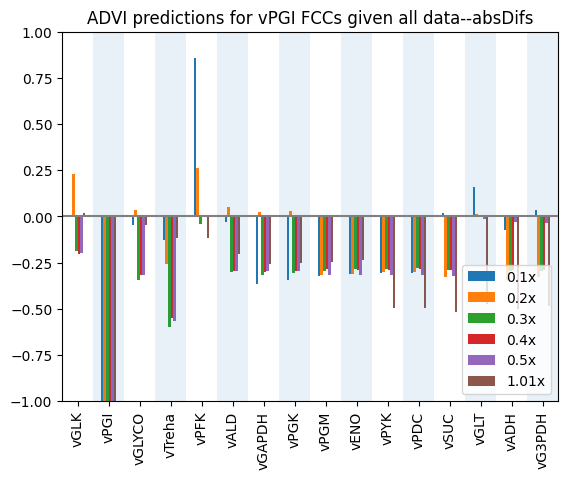

<Figure size 1600x1000 with 0 Axes>

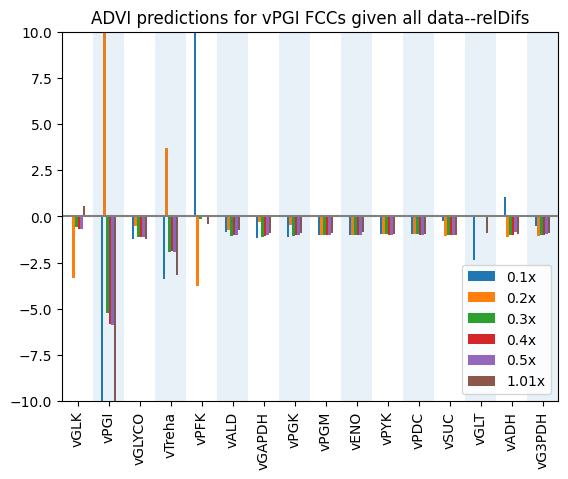

<Figure size 1600x1000 with 0 Axes>

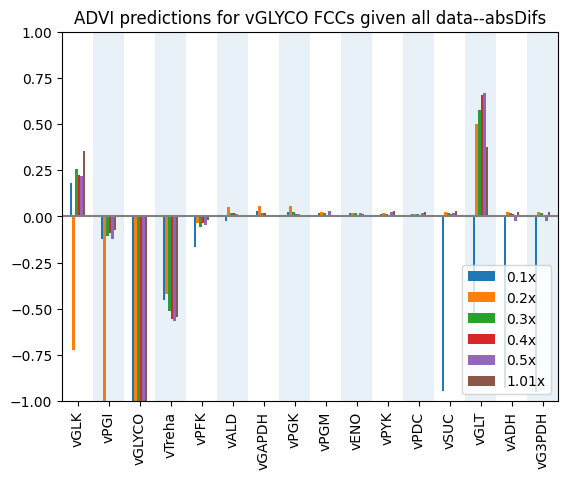

<Figure size 1600x1000 with 0 Axes>

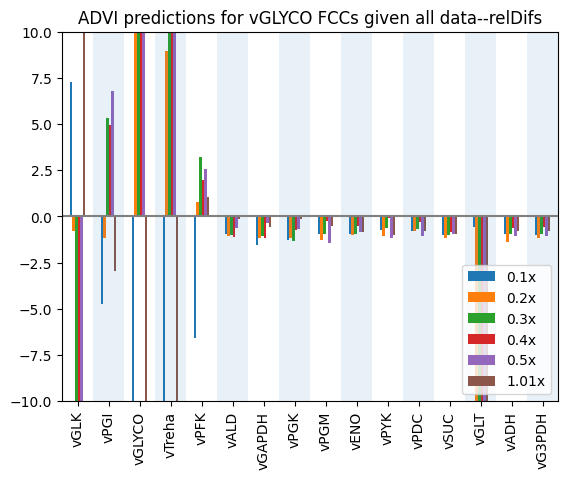

<Figure size 1600x1000 with 0 Axes>

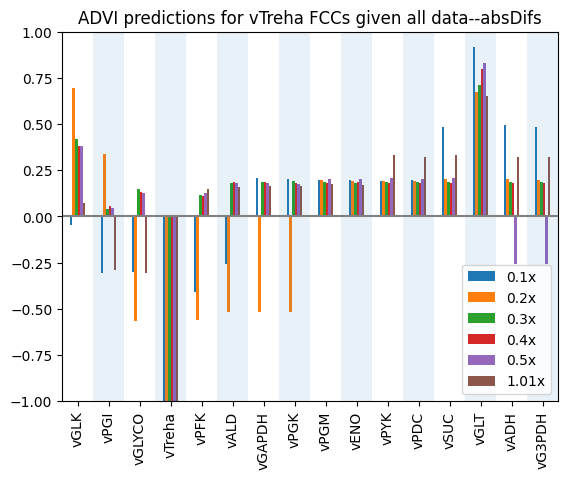

<Figure size 1600x1000 with 0 Axes>

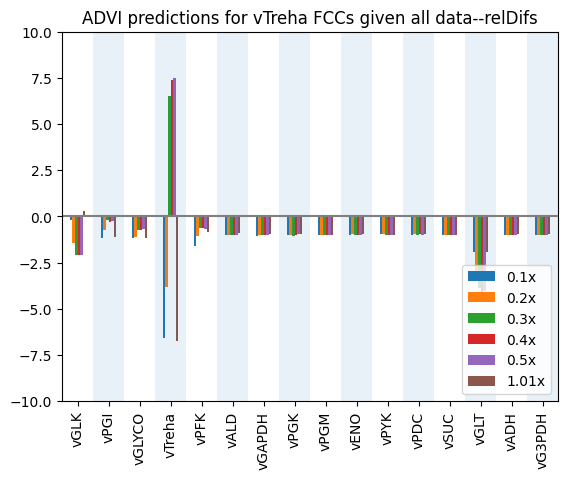

<Figure size 1600x1000 with 0 Axes>

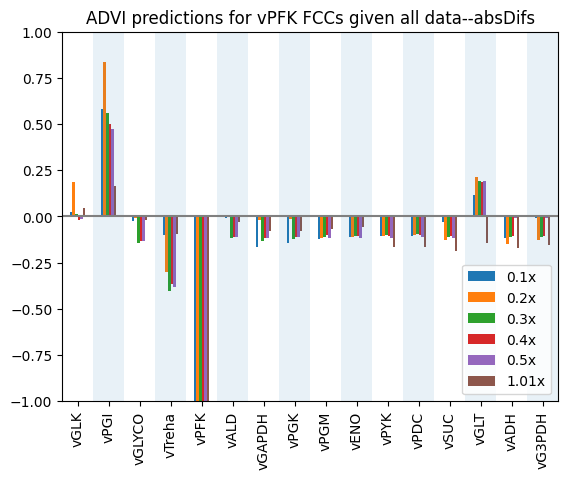

<Figure size 1600x1000 with 0 Axes>

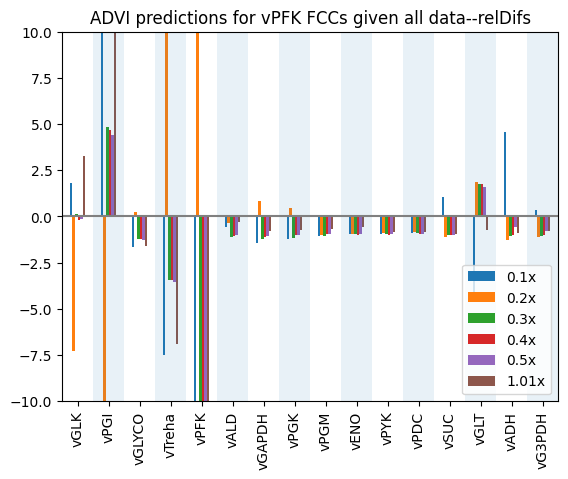

<Figure size 1600x1000 with 0 Axes>

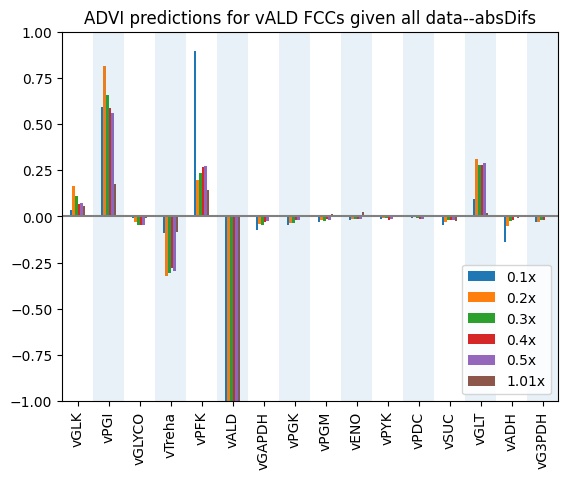

<Figure size 1600x1000 with 0 Axes>

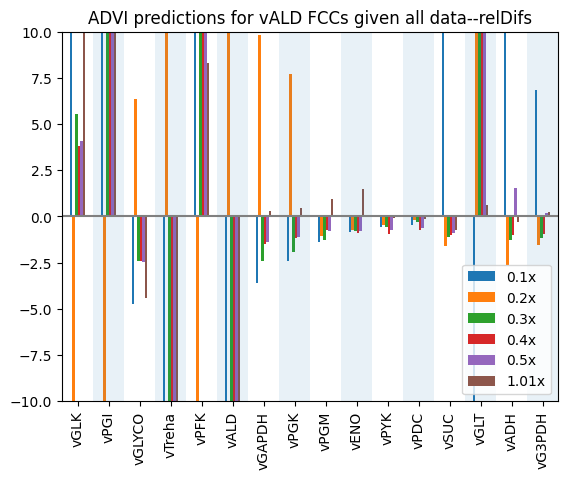

<Figure size 1600x1000 with 0 Axes>

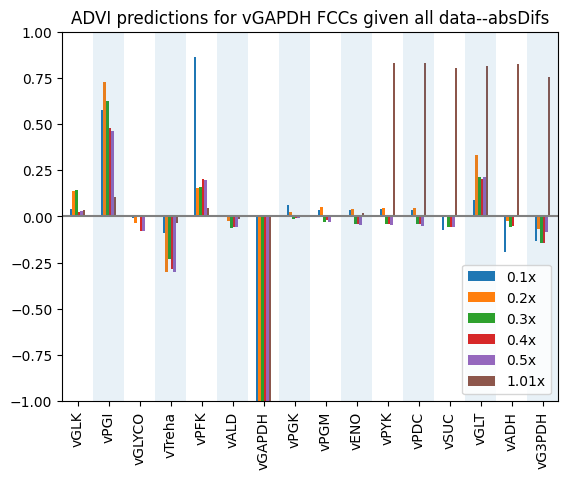

<Figure size 1600x1000 with 0 Axes>

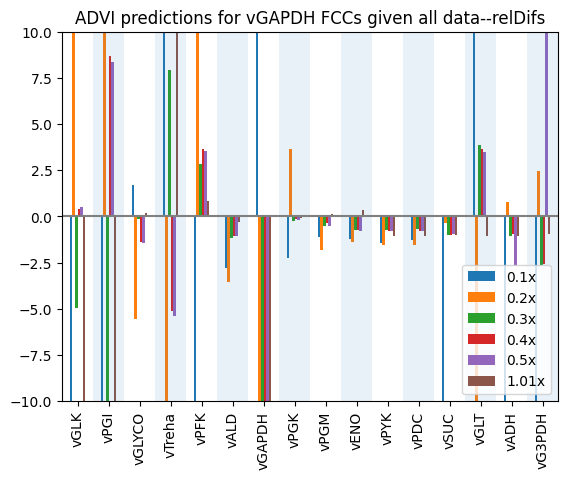

<Figure size 1600x1000 with 0 Axes>

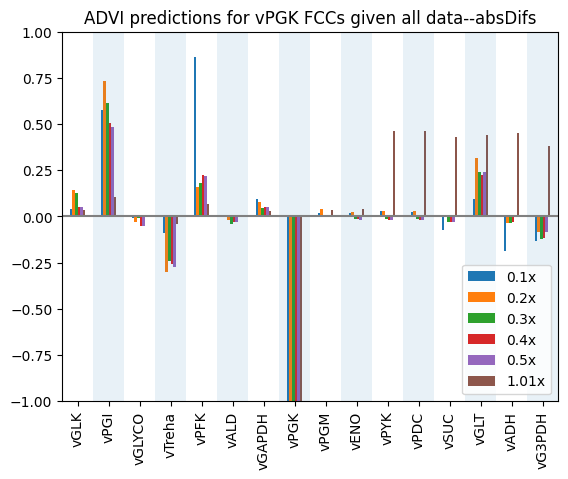

<Figure size 1600x1000 with 0 Axes>

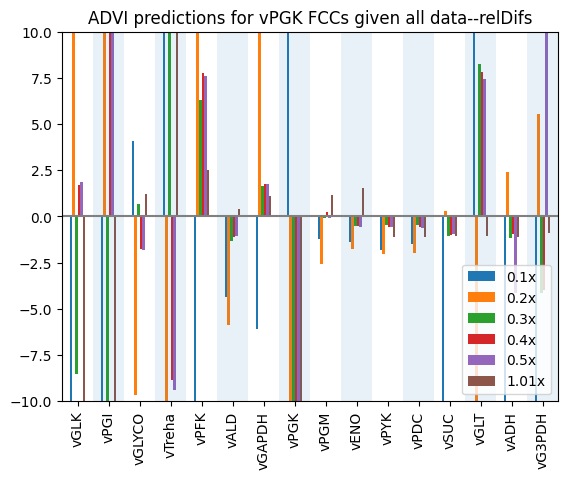

<Figure size 1600x1000 with 0 Axes>

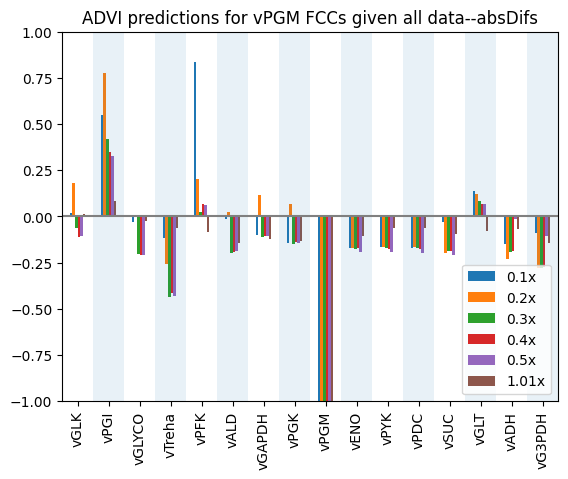

<Figure size 1600x1000 with 0 Axes>

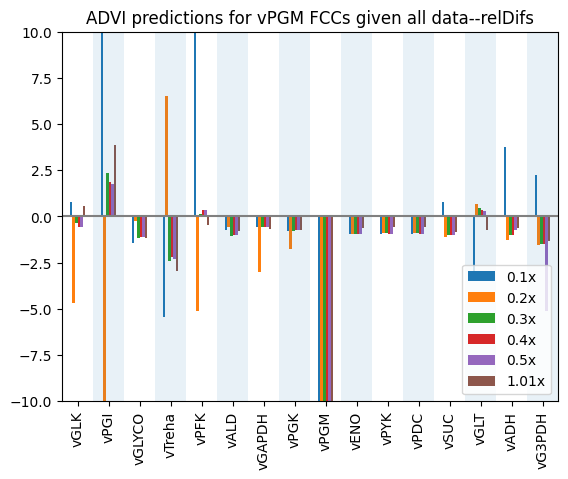

<Figure size 1600x1000 with 0 Axes>

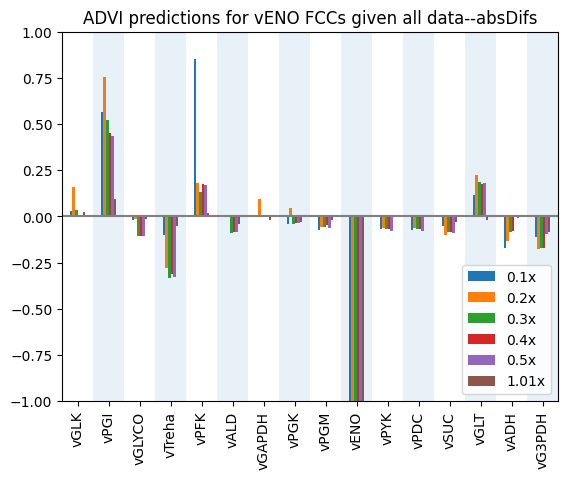

<Figure size 1600x1000 with 0 Axes>

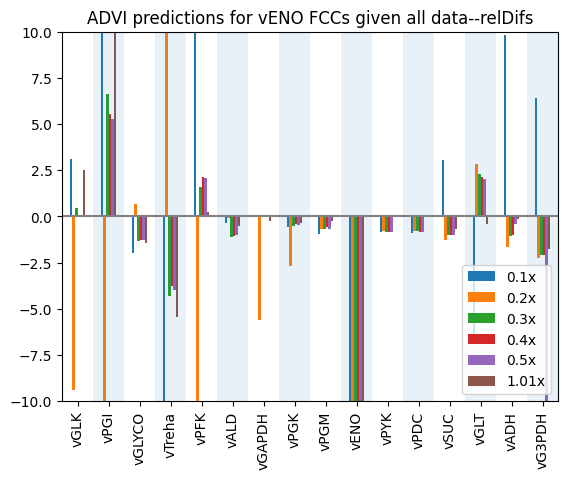

<Figure size 1600x1000 with 0 Axes>

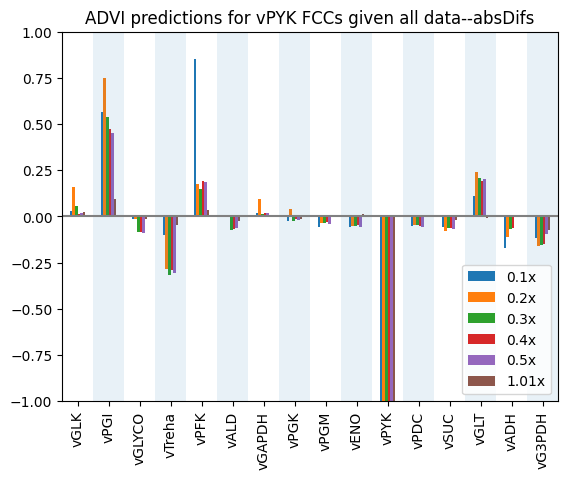

<Figure size 1600x1000 with 0 Axes>

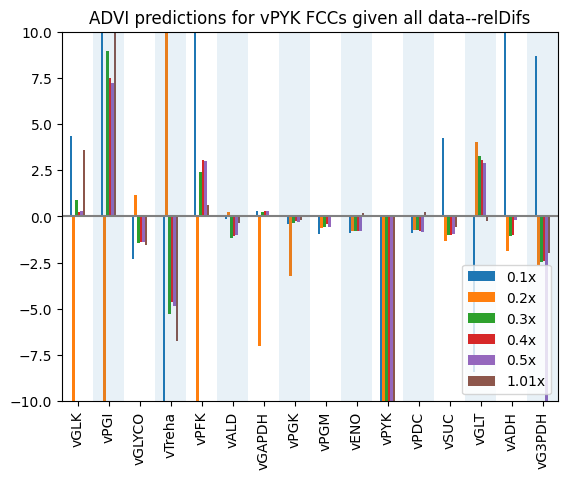

<Figure size 1600x1000 with 0 Axes>

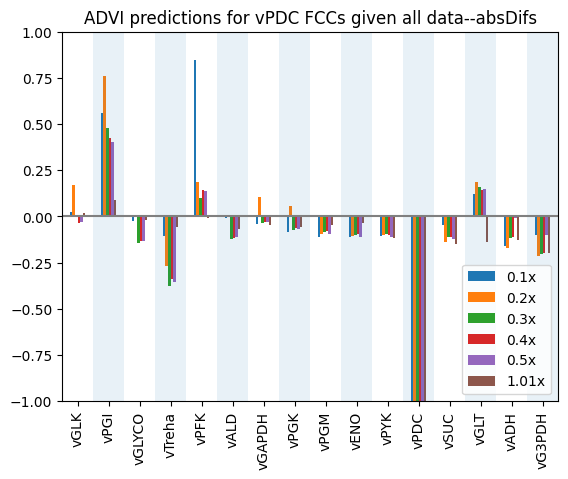

<Figure size 1600x1000 with 0 Axes>

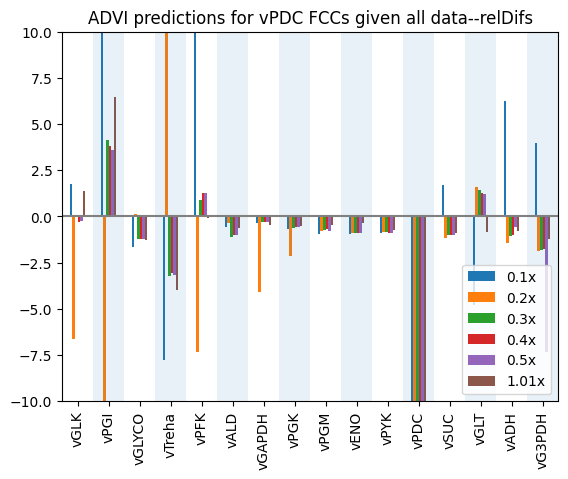

<Figure size 1600x1000 with 0 Axes>

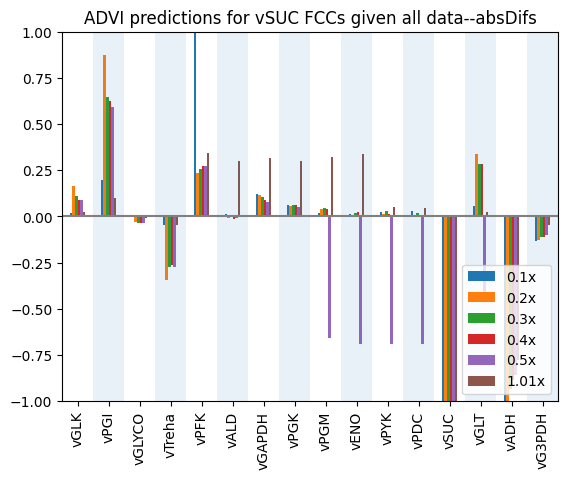

<Figure size 1600x1000 with 0 Axes>

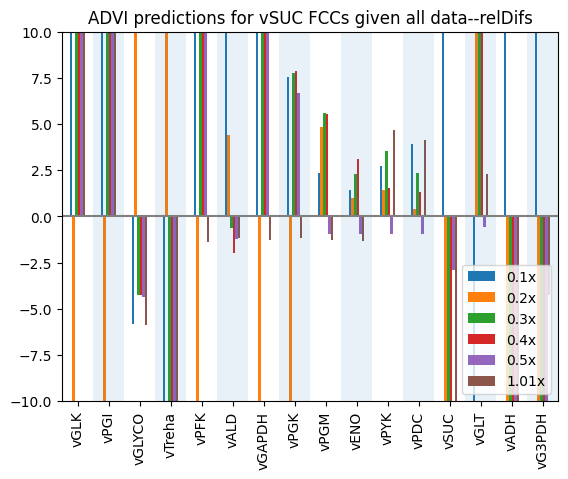

<Figure size 1600x1000 with 0 Axes>

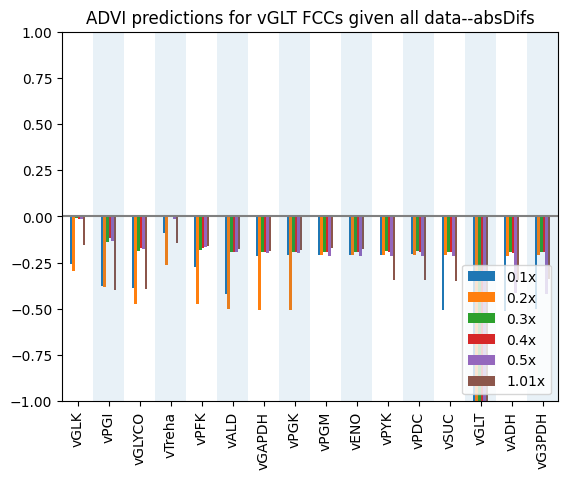

<Figure size 1600x1000 with 0 Axes>

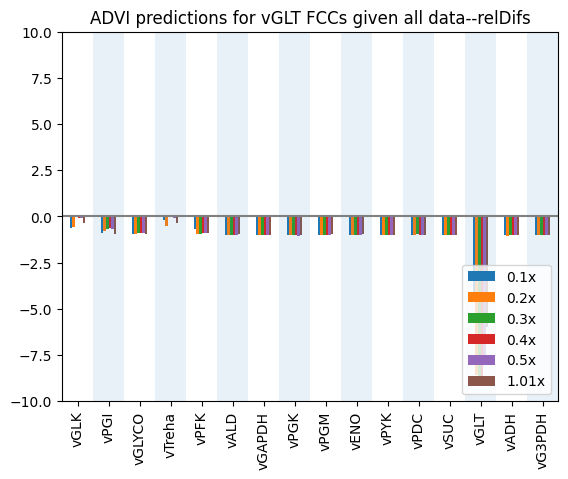

<Figure size 1600x1000 with 0 Axes>

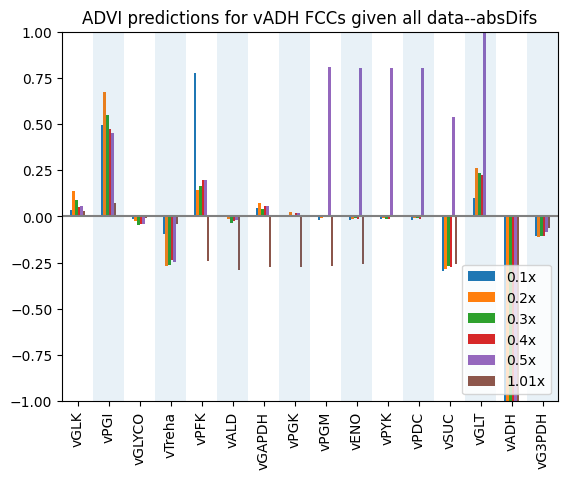

<Figure size 1600x1000 with 0 Axes>

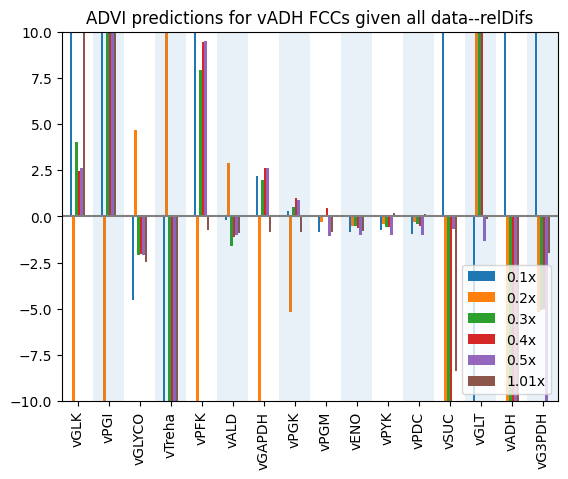

<Figure size 1600x1000 with 0 Axes>

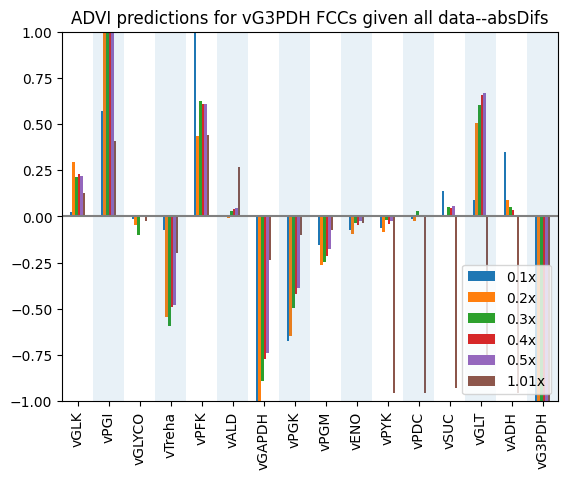

<Figure size 1600x1000 with 0 Axes>

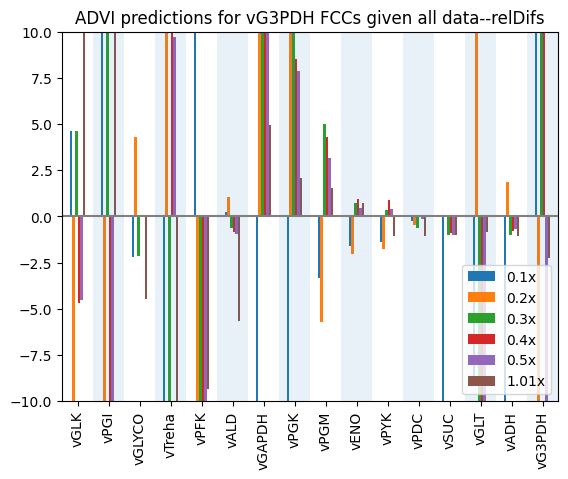

In [17]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')

In [18]:
plt.close("all")

## Evaluating FCC ranking

In [19]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
# gtFCC_rankings

In [20]:
m1 = gtFCC_rankings.isin([1.0])  
m2 = gtFCC_rankings.isin([2.0])  
m3 = gtFCC_rankings.isin([3.0])  
a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

trueRanks = pd.concat([a,b,c], axis=1)
trueRanks['topThree'] = trueRanks[0] + trueRanks[1] + trueRanks[2]

In [21]:
rxn_FCCs = [postFCC01,postFCC02,postFCC03,postFCC04,postFCC05, postFCC10]
scores = []
for pt_level in rxn_FCCs:
    postFCC_med=pd.DataFrame(np.median(pt_level, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    # m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
    postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
    postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
  
    m1 = postFCC_med_rankings.isin([1.0])  
    m2 = postFCC_med_rankings.isin([2.0])  
    m3 = postFCC_med_rankings.isin([3.0])  
    a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

    prdRanks = pd.concat([a,b,c], axis=1)
    prdRanks['topThree'] = prdRanks[0] + prdRanks[1] + prdRanks[2]

    scores.append([len([i for i in prdRanks['topThree'][rxn] if i in trueRanks['topThree'][rxn]]) for rxn in r.getReactionIds()])

topThreeCheckdf = pd.DataFrame(scores, columns=r.getReactionIds(), index=pt_labels).T

In [22]:
topThreeCheckdf.style.background_gradient(cmap='RdYlBu', axis=None)
# sns.heatmap(topThreeCheckdf, annot=True, cmap='RdYlBu')

,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
vGLK,1,3,2,3,2,2
vPGI,0,2,1,2,1,1
vGLYCO,2,3,2,3,2,3
vTreha,1,3,2,3,2,2
vPFK,1,3,2,3,2,2
vALD,0,3,2,2,1,2
vGAPDH,0,2,1,2,1,1
vPGK,0,2,1,2,1,1
vPGM,0,3,2,2,1,1
vENO,0,2,1,2,1,2


In [23]:
topThreeCheckdf.sum(axis=0)

0.1x      9
0.2x     40
0.3x     25
0.4x     39
0.5x     23
1.01x    27
dtype: int64